In [4]:
import dotenv

dotenv.load_dotenv()

True

In [ ]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
from cavmir.evaluation import calculate_tcav_score
from cavmir.utils import load_embeddings

s3 = s3fs.S3FileSystem()

trainings_prefix = os.environ["TRAININGS_PREFIX"]
dataset_prefix = os.environ["DATASET_PREFIX"]
embedding_prefix = os.environ["EMBEDDING_PREFIX"]


def calculate_tcav_scores(
    cav_vector: np.ndarray,
    df: pd.DataFrame,
    target_column: str,
    embedding_prefix: str,
    encoder_id: str,
) -> dict[str, float]:
    target_labels = df[target_column].unique()

    tcav_scores = {}
    for target_label in target_labels:
        print(f"Calculating TCAV score for {target_label}...")
        df_subset = df[df[target_column] == target_label]
        target_embeddings = load_embeddings(df_subset, embedding_prefix, encoder_id, s3)
        tcav_scores[target_label] = calculate_tcav_score(cav_vector, target_embeddings)

    return tcav_scores


def plot_tcav_scores(
    tcav_scores: dict[str, float],
    project_name: str,
    encoder_id: str,
    target_column: str,
):
    """
    Creates a relative bar plot of the TCAV scores for each target label.
    """

    tcav_scores = dict(sorted(tcav_scores.items(), key=lambda x: x[1], reverse=True))

    plt.bar([*tcav_scores.keys()], [score - 0.5 for score in tcav_scores.values()])
    plt.axhline(0, color="black", linewidth=0.5)

    plt.figure(figsize=(18, 5))
    plt.xticks(rotation=60)
    plt.ylim(-0.5, 0.5)
    plt.yticks(np.arange(-0.5, 0.6, 0.1))
    plt.title(f"Evaluating {project_name} with {encoder_id} on {target_column}")
    plt.grid()
    plt.show()


def run_evaluations(evaluation_variations: list[tuple]):
    for project_name, encoder_id, target_column in evaluation_variations:
        print(f"Evaluating {project_name} with {encoder_id} on {target_column}")

        df_test = pd.read_csv(
            os.path.join(dataset_prefix, f"test_dataset_{project_name}.csv")
        )

        cav_vector_dir = os.path.join(
            trainings_prefix,
            encoder_id,
            project_name.split("_")[0],
            "trainings",
            project_name,
            f"cav_{project_name}.npy",
        )

        cav_vector = np.load(cav_vector_dir)

        tcav_scores = calculate_tcav_scores(
            cav_vector, df_test, target_column, embedding_prefix, encoder_id
        )

        plot_tcav_scores(tcav_scores, project_name, encoder_id, target_column)


### Gender Evaluation


In [31]:
project_names = ["gender_female", "gender_male"]
encoder_ids = ["mert_v1_95m", "whisper_large_turbo"]
target_columns = ["genre"]

Evaluating gender_female with mert_v1_95m on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for asian_music...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for metal...
Calculating TCAV score for indian_music...
Calculating TCAV score for brazilian_music...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for blues...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...
Calculating TCAV score for reggae...
Calculating TCAV score for christian...


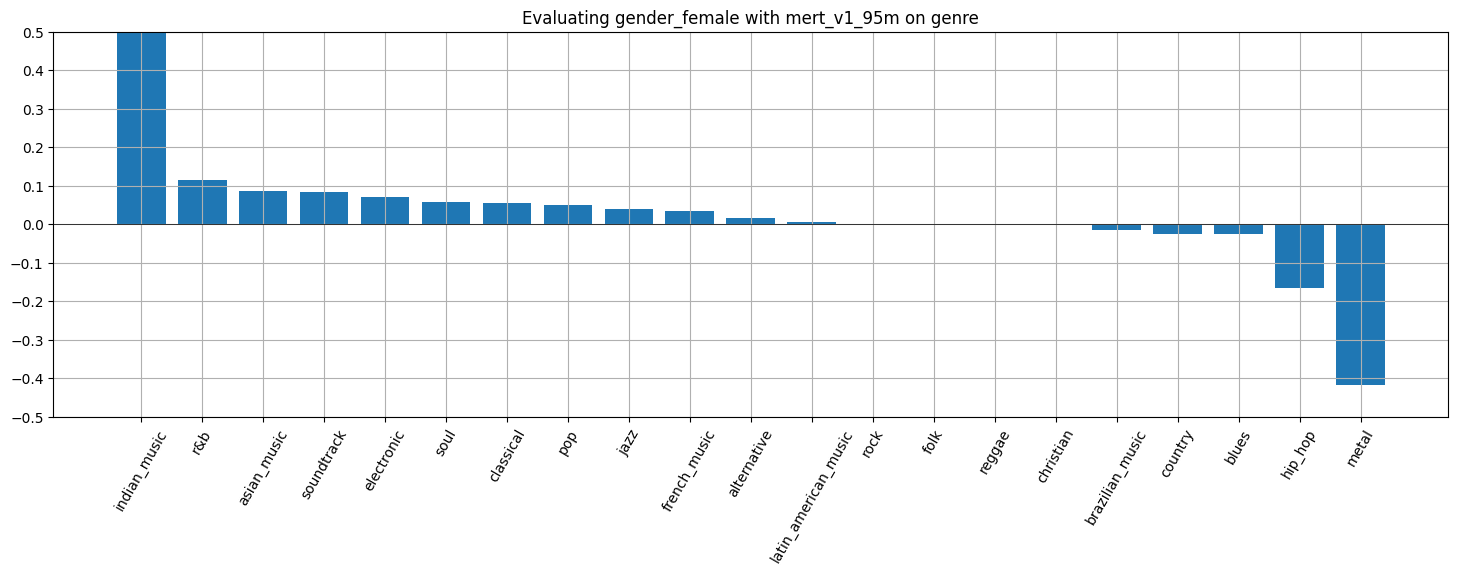

Evaluating gender_female with whisper_large_turbo on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for asian_music...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for metal...
Calculating TCAV score for indian_music...
Calculating TCAV score for brazilian_music...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for blues...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...
Calculating TCAV score for reggae...
Calculating TCAV score for christian...


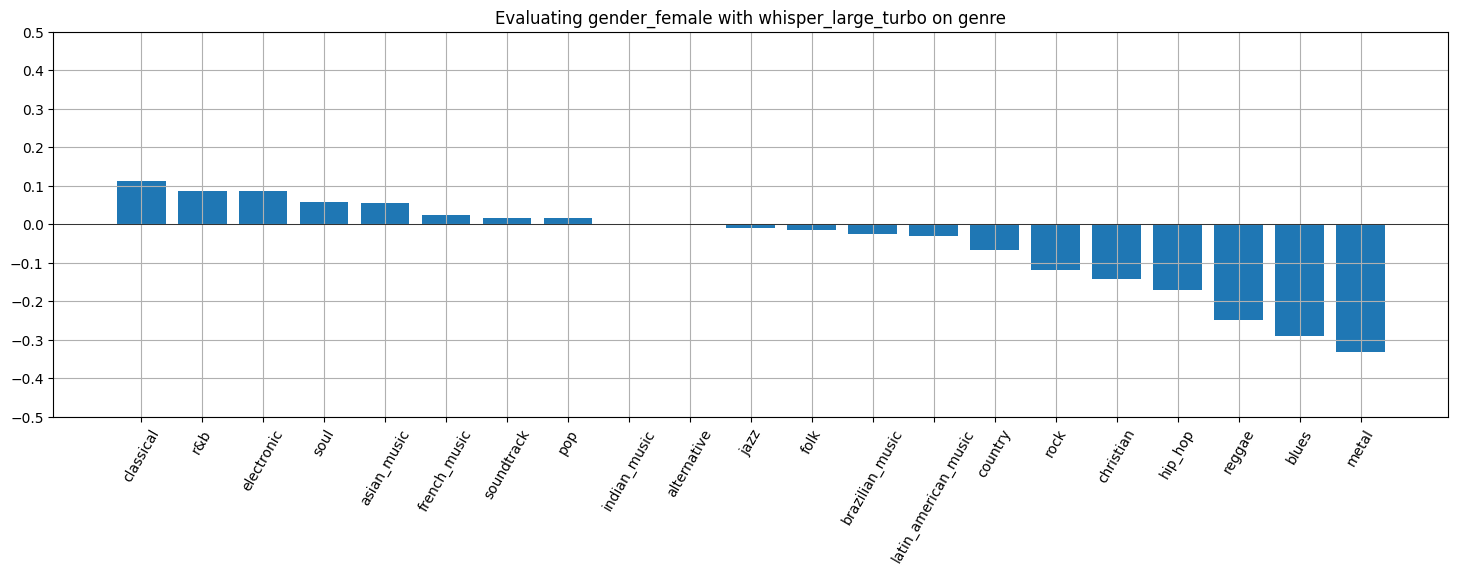

Evaluating gender_male with mert_v1_95m on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for asian_music...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for metal...
Calculating TCAV score for indian_music...
Calculating TCAV score for brazilian_music...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for blues...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...
Calculating TCAV score for reggae...
Calculating TCAV score for christian...


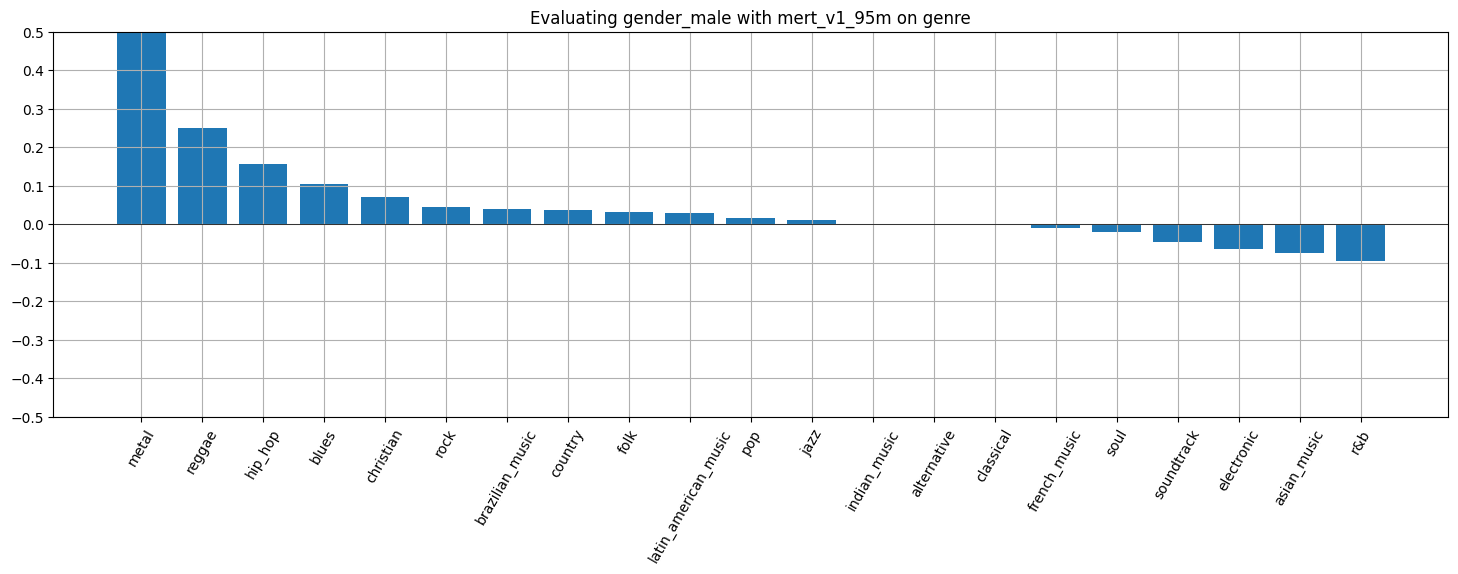

Evaluating gender_male with whisper_large_turbo on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for asian_music...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for metal...
Calculating TCAV score for indian_music...
Calculating TCAV score for brazilian_music...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for blues...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...
Calculating TCAV score for reggae...
Calculating TCAV score for christian...


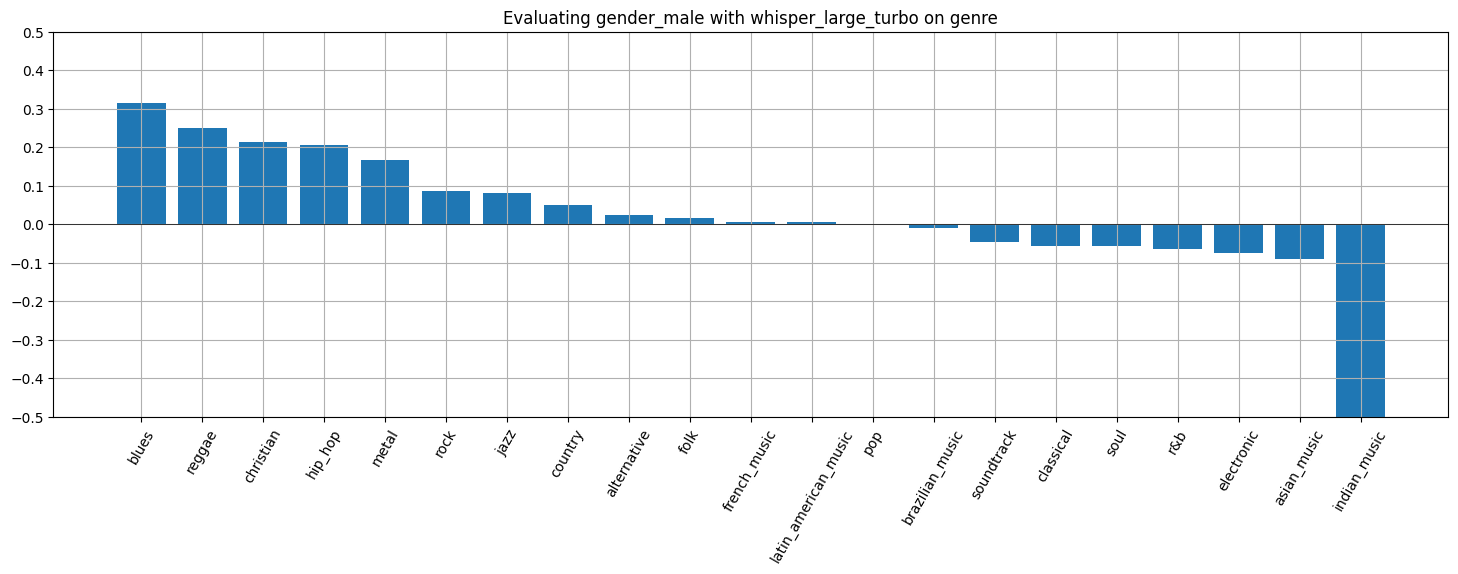

In [32]:
evaluation_variations = [*itertools.product(project_names, encoder_ids, target_columns)]

run_evaluations(evaluation_variations)

### Language Evaluation


In [6]:
project_names = [
    "language_de",
    "language_en",
    "language_es",
    "language_fr",
    "language_it",
    "language_ja",
    "language_pt",
]
encoder_ids = ["mert_v1_95m", "whisper_large_turbo"]
target_columns = ["genre"]

Evaluating language_de with mert_v1_95m on genre
Calculating TCAV score for pop...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for metal...
Calculating TCAV score for electronic...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...


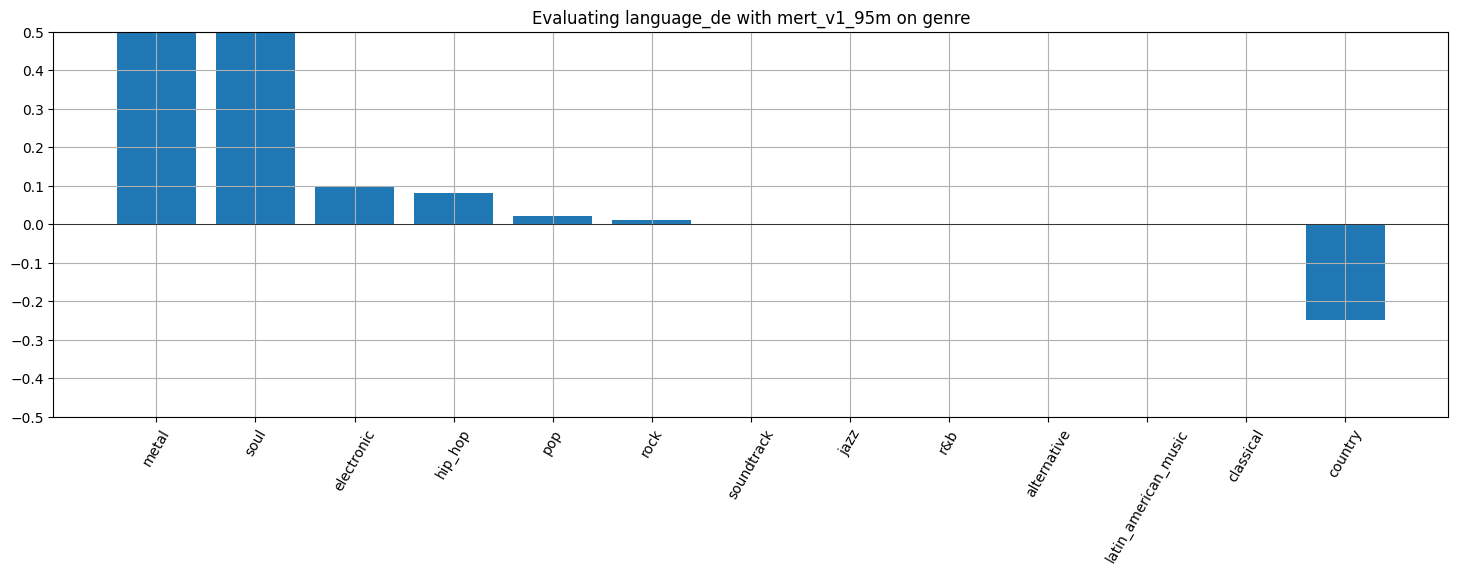

Evaluating language_de with whisper_large_turbo on genre
Calculating TCAV score for pop...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for metal...
Calculating TCAV score for electronic...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...


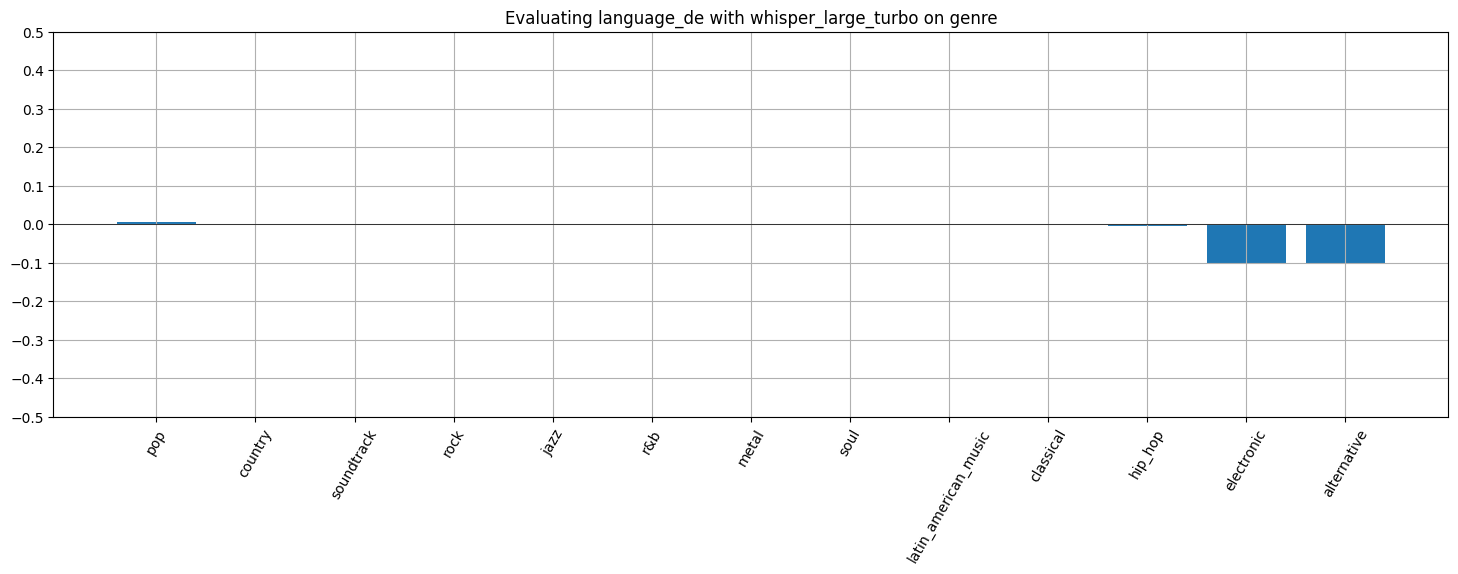

Evaluating language_en with mert_v1_95m on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for asian_music...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for metal...
Calculating TCAV score for brazilian_music...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for blues...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...
Calculating TCAV score for reggae...
Calculating TCAV score for christian...
Calculating TCAV score for african_music...


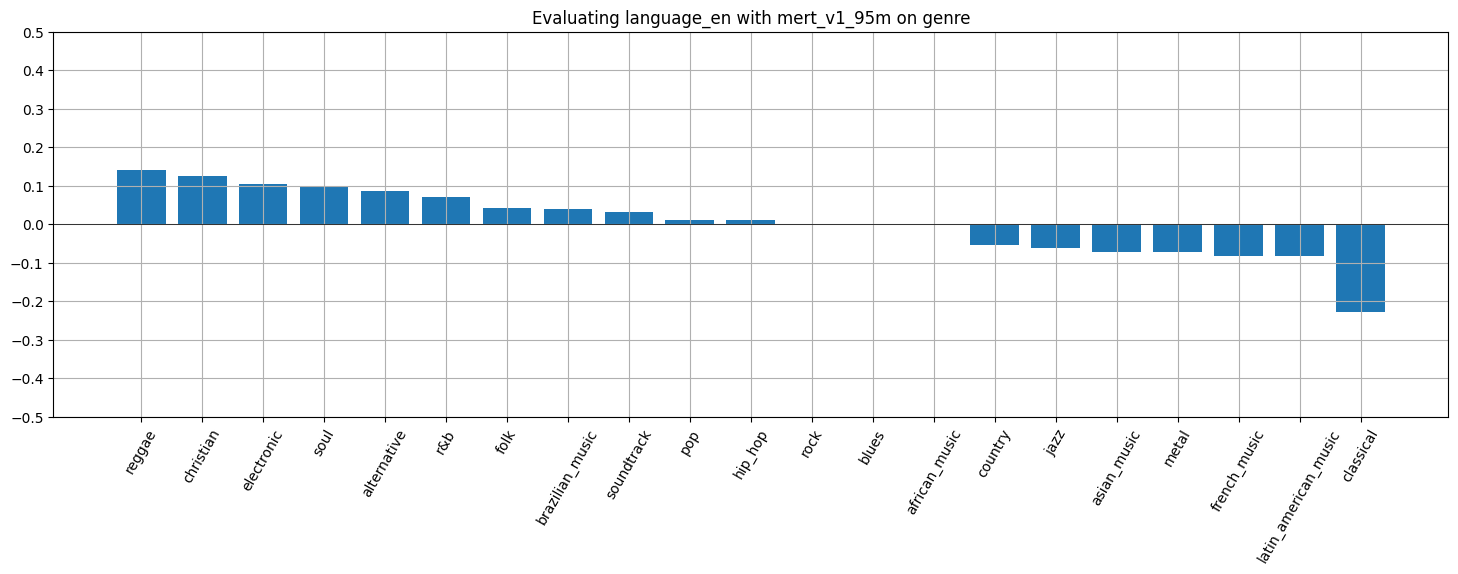

Evaluating language_en with whisper_large_turbo on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for asian_music...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for metal...
Calculating TCAV score for brazilian_music...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for blues...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...
Calculating TCAV score for reggae...
Calculating TCAV score for christian...
Calculating TCAV score for african_music...


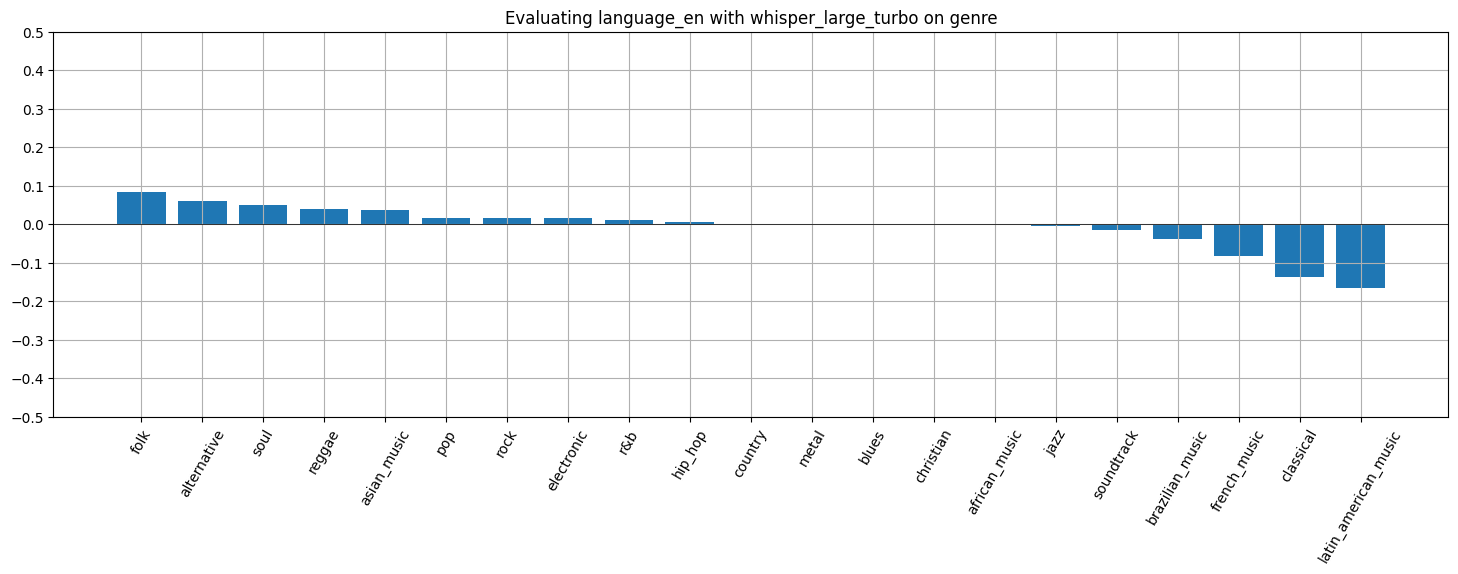

Evaluating language_es with mert_v1_95m on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for metal...
Calculating TCAV score for brazilian_music...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for blues...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...
Calculating TCAV score for christian...


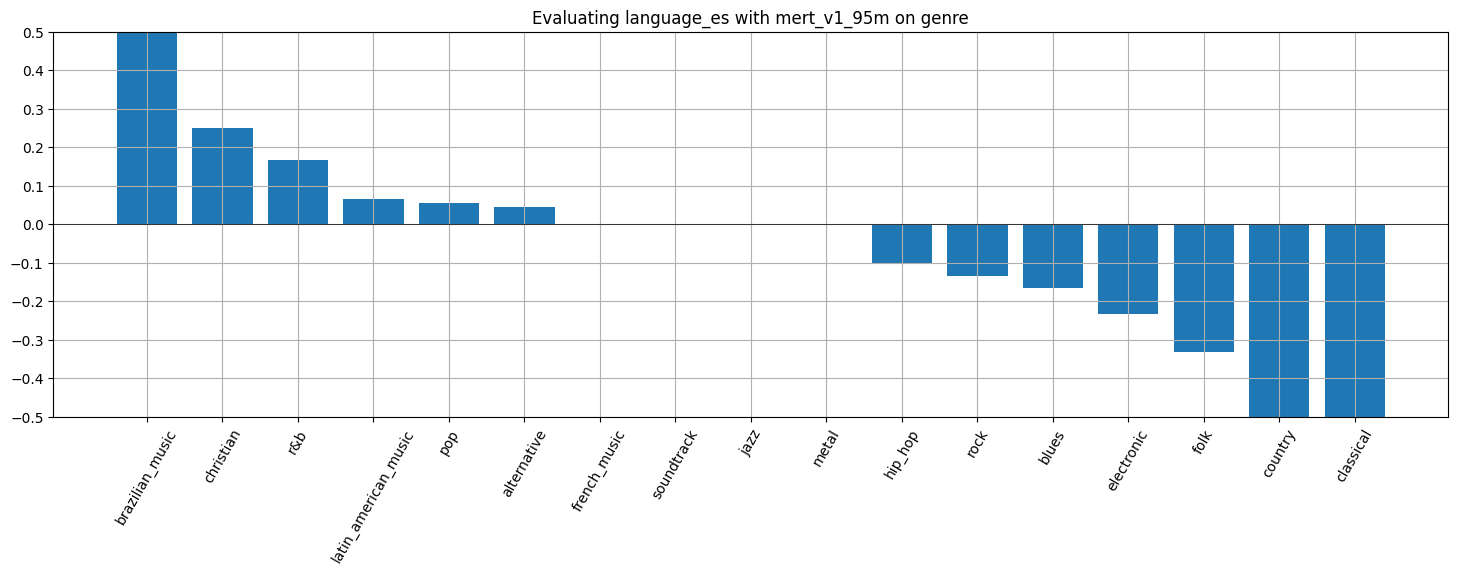

Evaluating language_es with whisper_large_turbo on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for metal...
Calculating TCAV score for brazilian_music...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for blues...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...
Calculating TCAV score for christian...


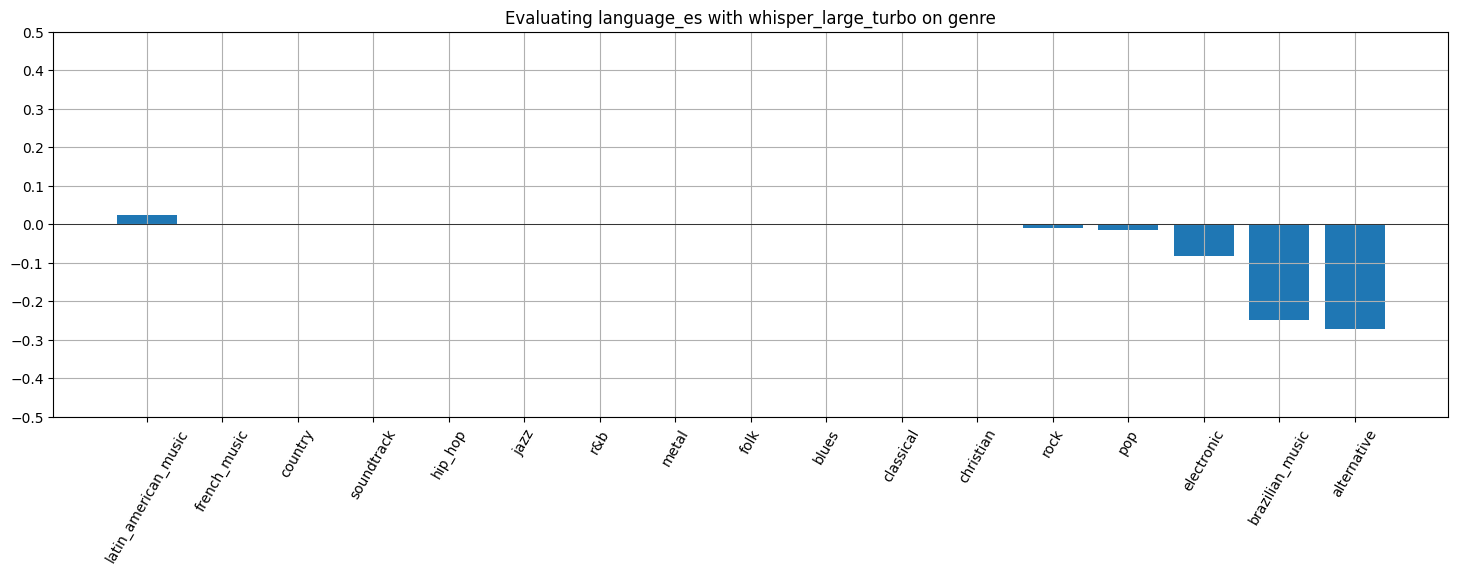

Evaluating language_fr with mert_v1_95m on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for metal...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...
Calculating TCAV score for reggae...
Calculating TCAV score for african_music...


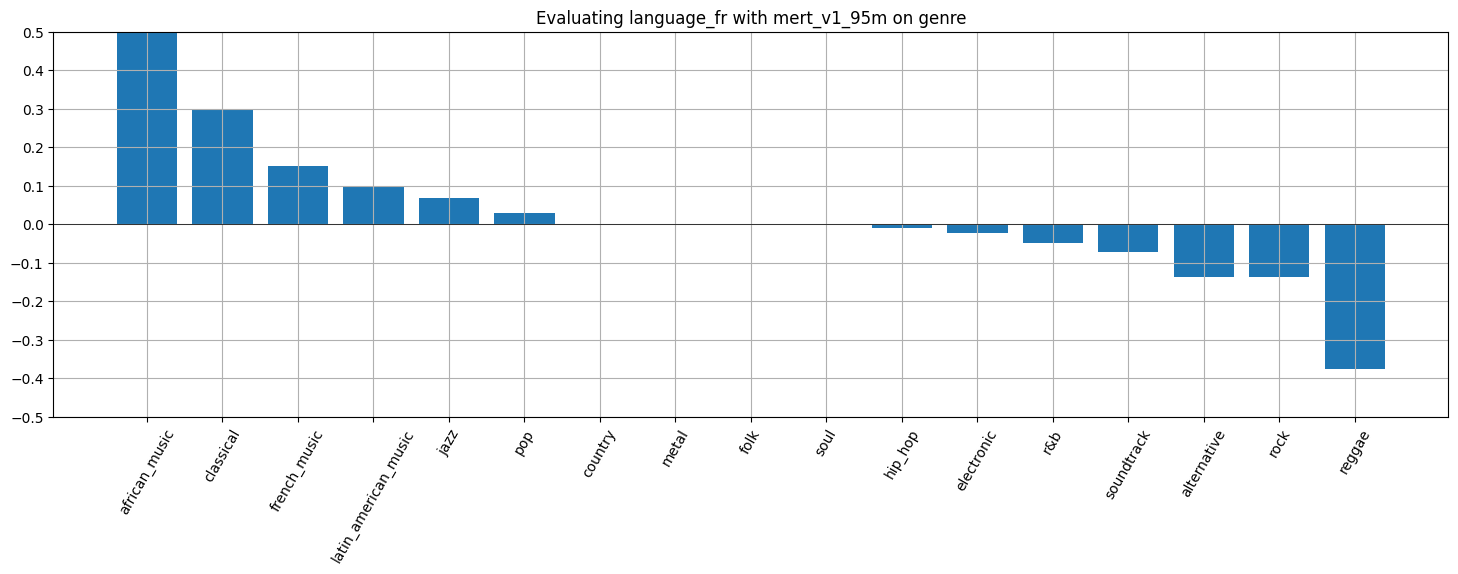

Evaluating language_fr with whisper_large_turbo on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for metal...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...
Calculating TCAV score for reggae...
Calculating TCAV score for african_music...


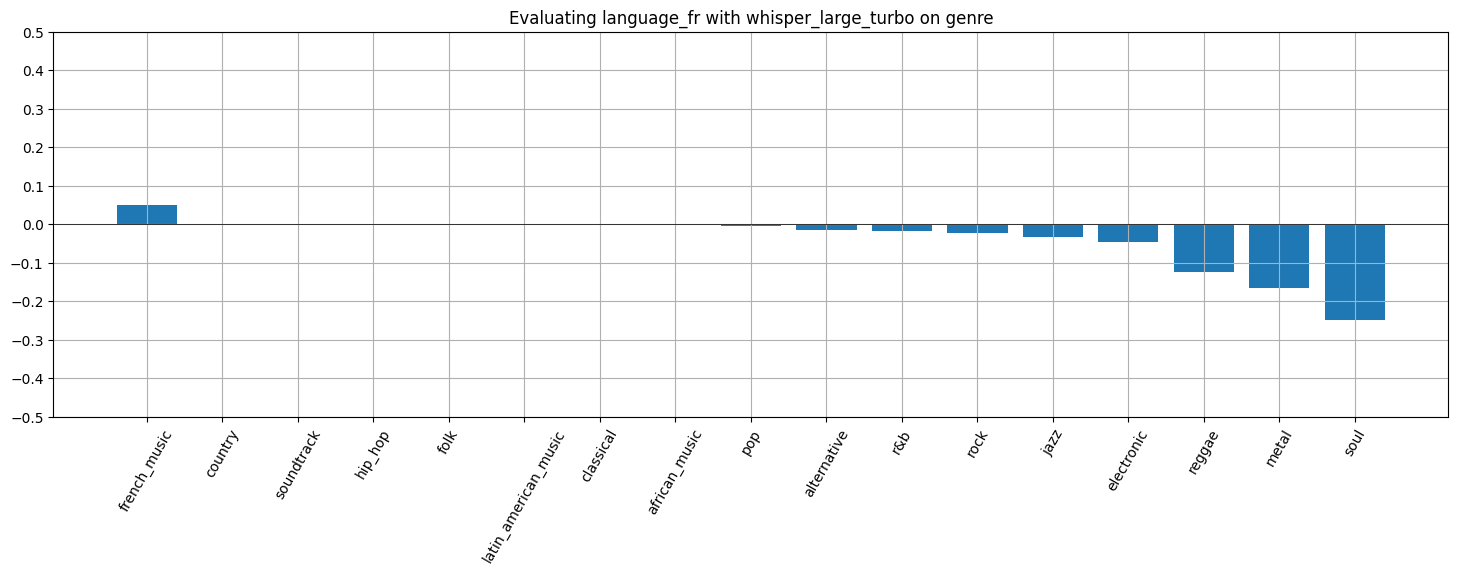

Evaluating language_it with mert_v1_95m on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for brazilian_music...
Calculating TCAV score for electronic...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...


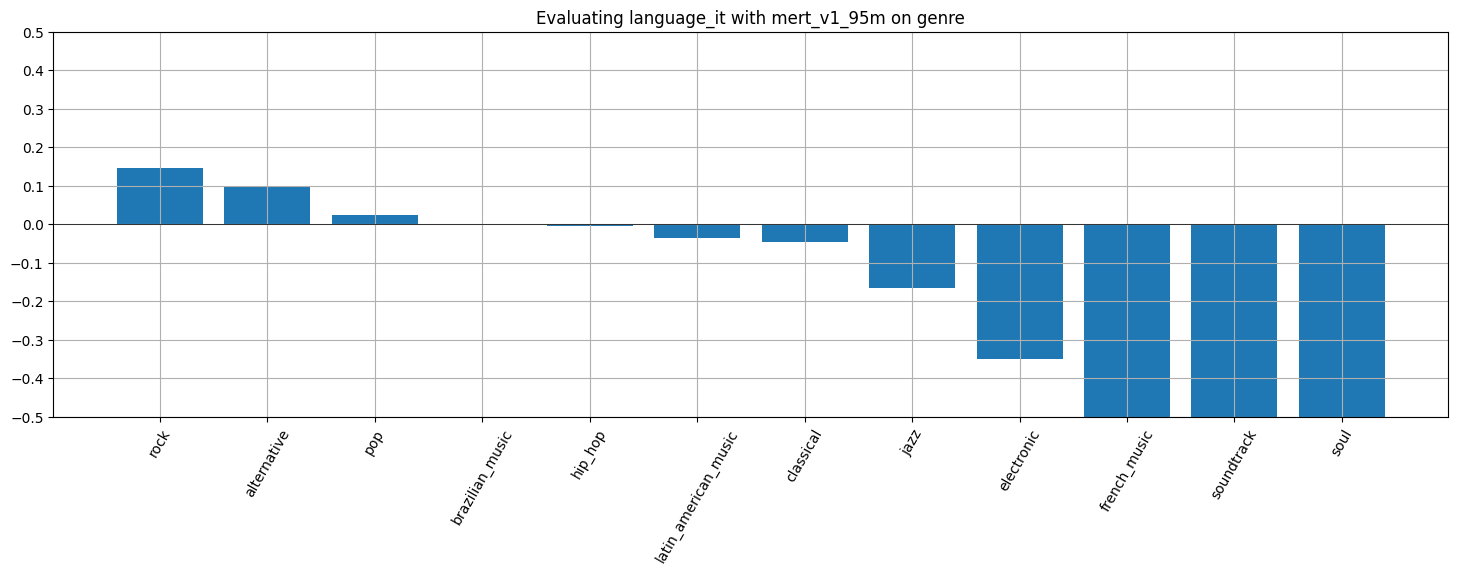

Evaluating language_it with whisper_large_turbo on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for brazilian_music...
Calculating TCAV score for electronic...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for classical...


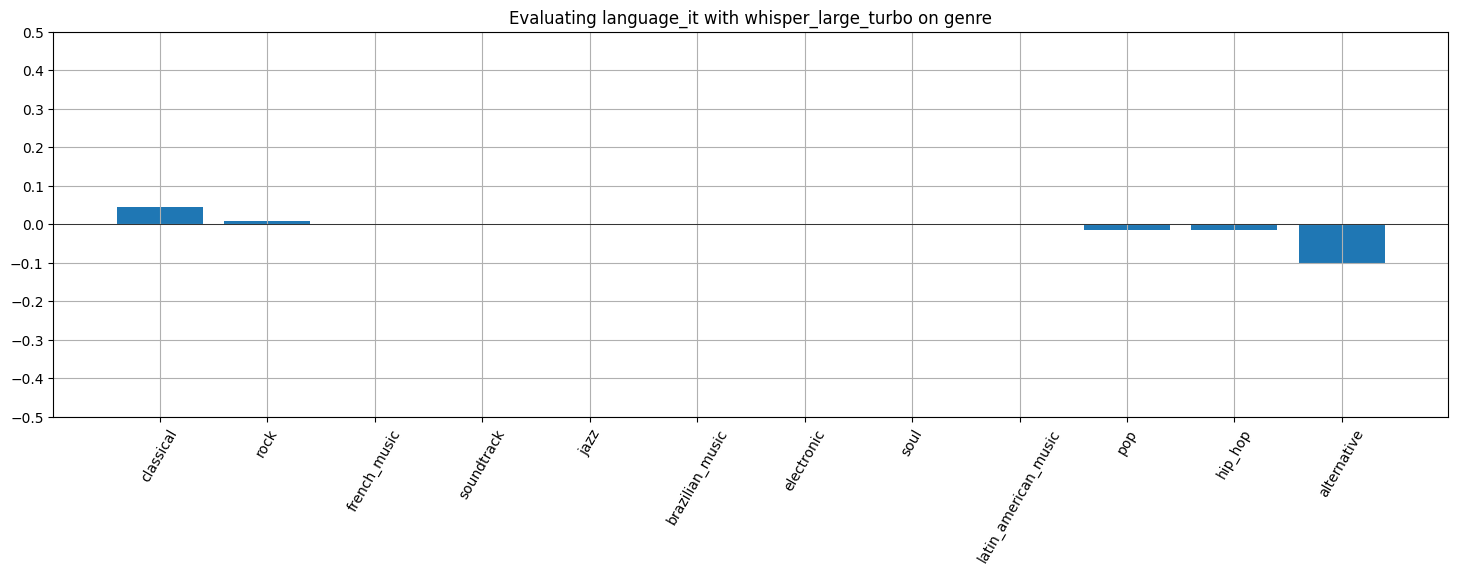

Evaluating language_ja with mert_v1_95m on genre
Calculating TCAV score for pop...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for asian_music...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for reggae...


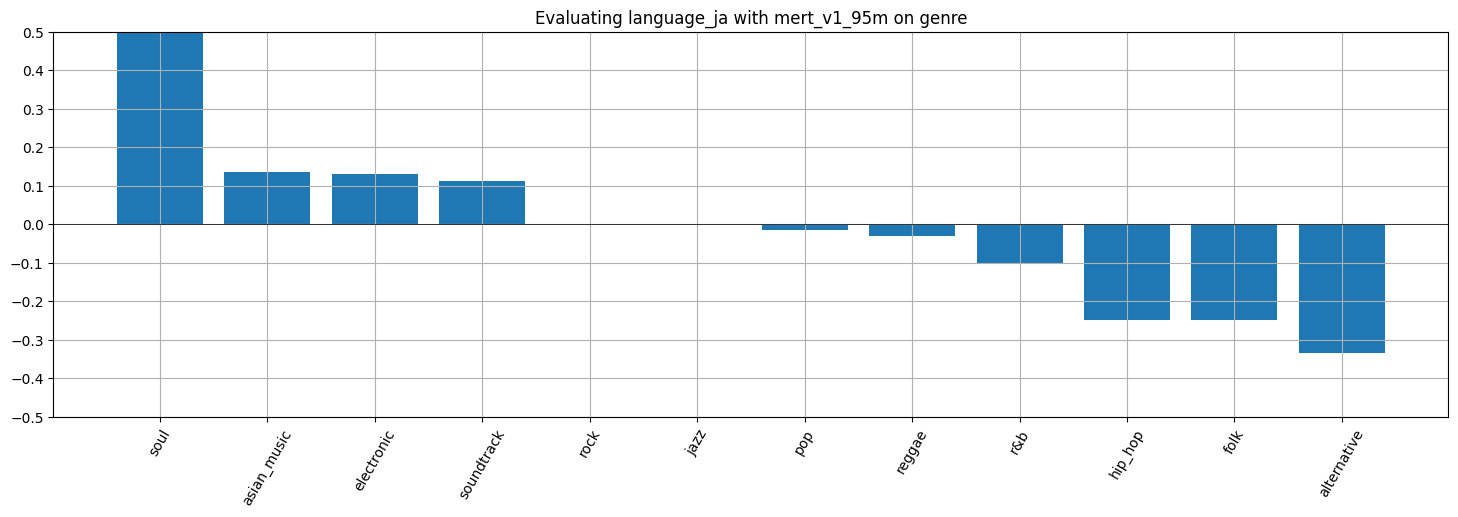

Evaluating language_ja with whisper_large_turbo on genre
Calculating TCAV score for pop...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for asian_music...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for reggae...


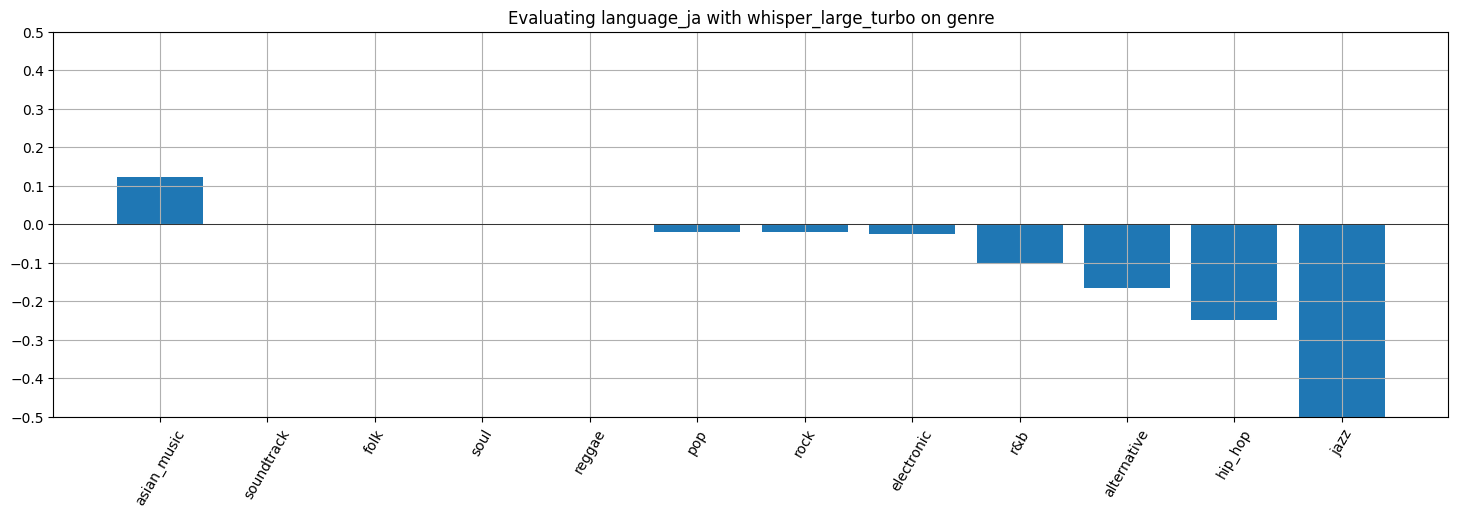

Evaluating language_pt with mert_v1_95m on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for asian_music...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for brazilian_music...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for blues...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for reggae...
Calculating TCAV score for christian...


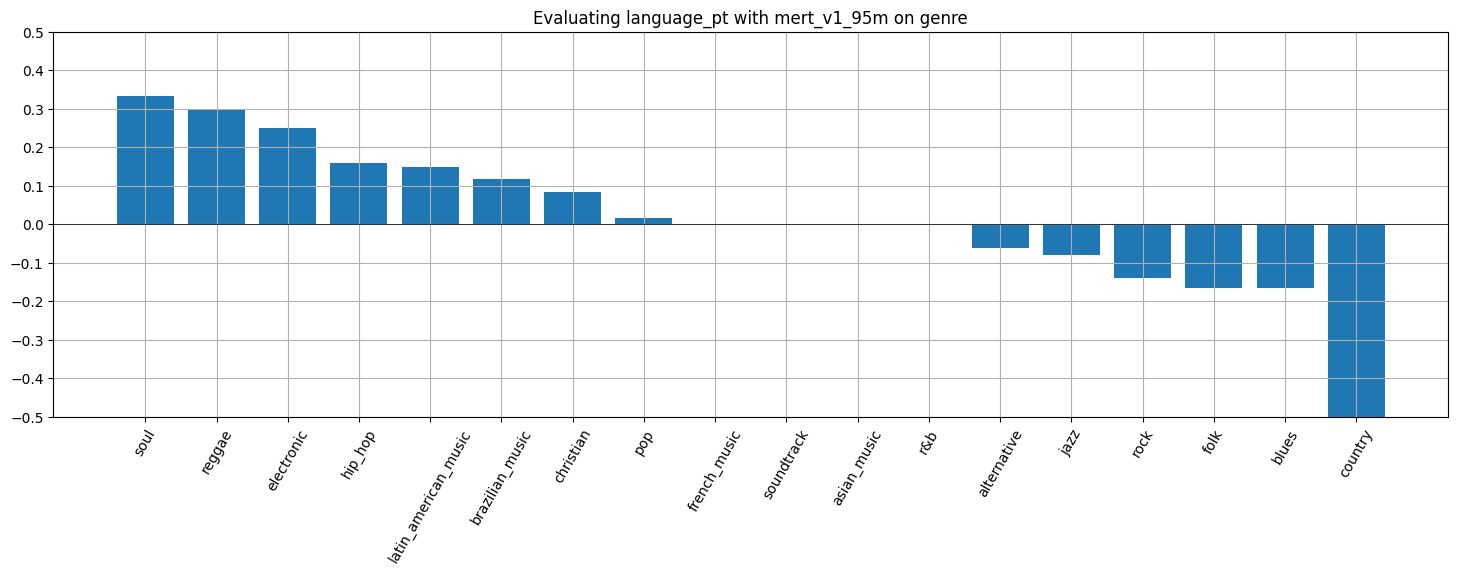

Evaluating language_pt with whisper_large_turbo on genre
Calculating TCAV score for pop...
Calculating TCAV score for french_music...
Calculating TCAV score for country...
Calculating TCAV score for soundtrack...
Calculating TCAV score for hip_hop...
Calculating TCAV score for asian_music...
Calculating TCAV score for rock...
Calculating TCAV score for jazz...
Calculating TCAV score for r&b...
Calculating TCAV score for brazilian_music...
Calculating TCAV score for electronic...
Calculating TCAV score for folk...
Calculating TCAV score for alternative...
Calculating TCAV score for soul...
Calculating TCAV score for blues...
Calculating TCAV score for latin_american_music...
Calculating TCAV score for reggae...
Calculating TCAV score for christian...


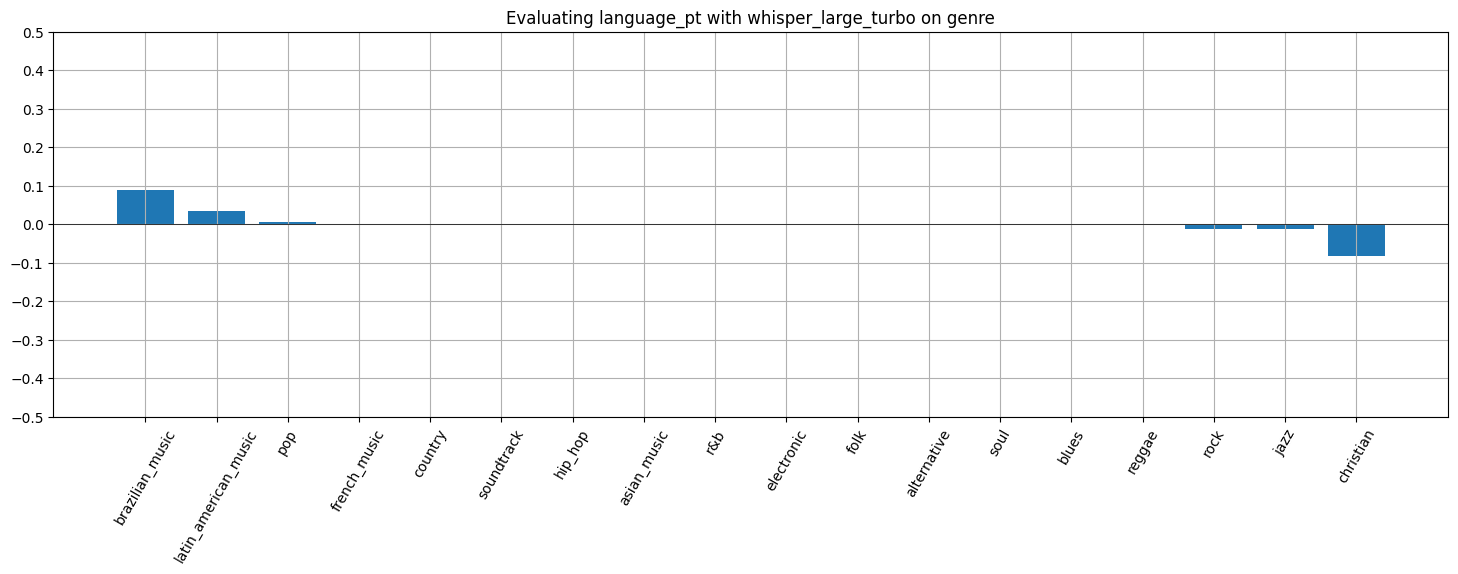

In [7]:
evaluation_variations = [*itertools.product(project_names, encoder_ids, target_columns)]

run_evaluations(evaluation_variations)
